**Importing modules**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

**Creating the NN object**

In [3]:
layer_sizes = [784, 512, 256, 10]

# Define a simple neural network model
class Net(nn.Module):
    """" 
    This is a class Neural network implemented in pytorch. 
    It inherits from nn.Module and thereby makes sure that fancy functionalities 
    of Pytorch will be available for your neural network architecture. 
    """
    def __init__(self):
        super(Net, self).__init__()
        # Define your layers. Usually one defines linear layers and uses the relu function around these layers. 
        # A Linear layer is define via lin = nn.Linear(input_dim, output_dim)
        self.layers = nn.Sequential(
            nn.Linear(layer_sizes[0], layer_sizes[1]),
            nn.ReLU(),
            nn.Linear(layer_sizes[1], layer_sizes[2]),
            nn.ReLU(),
            nn.Linear(layer_sizes[2], layer_sizes[3])
        )

    def forward(self, x):
        # Define your evaluate function. You can use the pytorch relu function via torch.relu
        # You can call your linear layer at a given input x via self.lin(x)
        x = x.view(-1, 28 * 28)  # Flatten the input such that we have a vector
        x = self.layers(x)  # Pass through the defined layers
        return x

# Initialize the neural network model
net = Net()

**Network training**

In [9]:
# Use DataParallel to utilize multiple CPU cores (after the model creation)
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    net = nn.DataParallel(net)
else:
    print("Using CPU!")

# Move the model to the device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define data transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.00001, momentum=0.9)

# Training loop
for epoch in range(50):  # You can adjust the number of epochs
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Mini-Batch {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print("Training finished")

# Save the trained model
torch.save(net.state_dict(), 'mnist_model.pth')

Using 1 GPUs!
Epoch 1, Mini-Batch 100, Loss: 0.005
Epoch 1, Mini-Batch 200, Loss: 0.006
Epoch 1, Mini-Batch 300, Loss: 0.004
Epoch 1, Mini-Batch 400, Loss: 0.004
Epoch 1, Mini-Batch 500, Loss: 0.005
Epoch 1, Mini-Batch 600, Loss: 0.004
Epoch 1, Mini-Batch 700, Loss: 0.005
Epoch 1, Mini-Batch 800, Loss: 0.005
Epoch 1, Mini-Batch 900, Loss: 0.004
Epoch 2, Mini-Batch 100, Loss: 0.005
Epoch 2, Mini-Batch 200, Loss: 0.004
Epoch 2, Mini-Batch 300, Loss: 0.004
Epoch 2, Mini-Batch 400, Loss: 0.006
Epoch 2, Mini-Batch 500, Loss: 0.004
Epoch 2, Mini-Batch 600, Loss: 0.004
Epoch 2, Mini-Batch 700, Loss: 0.004
Epoch 2, Mini-Batch 800, Loss: 0.004
Epoch 2, Mini-Batch 900, Loss: 0.005
Epoch 3, Mini-Batch 100, Loss: 0.005
Epoch 3, Mini-Batch 200, Loss: 0.004
Epoch 3, Mini-Batch 300, Loss: 0.005
Epoch 3, Mini-Batch 400, Loss: 0.005
Epoch 3, Mini-Batch 500, Loss: 0.005
Epoch 3, Mini-Batch 600, Loss: 0.006
Epoch 3, Mini-Batch 700, Loss: 0.004
Epoch 3, Mini-Batch 800, Loss: 0.004
Epoch 3, Mini-Batch 900,

**Get the images**

In [13]:
cwd = Path.cwd()
data_dir = cwd.parent / 'data'

def get_mnist():
    return datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

def return_image(image_index, mnist_dataset):
    # Get the image and its corresponding label
    image, label = mnist_dataset[image_index]

    # Now, you have the image as a PyTorch tensor.
    # You can access its data as a matrix using .detach().numpy()
    image_matrix = image[0].detach().numpy()  # Grayscale image, so we select the first channel (index 0)

    return image_matrix.reshape(image_matrix.size), image_matrix, label

def read_from_file(name=data_dir / "image_19961.txt"):
        x = np.zeros(28 * 28)
        with open(name) as file:
                for i, line in enumerate(file):
                    # split and convert values to floats
                    x[i * 28 : (i+1)*28] = [float(value) for value in line.strip().split()]




**Running the network**

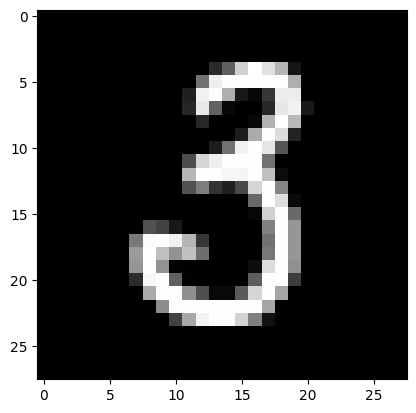

The response vector of the network is: 3
Image 46136 shows the number 3


In [28]:
# Choose an index to select one of the images
image_index = 46136
mnist_dataset = get_mnist()
x, image, label = return_image(image_index, mnist_dataset) # This here reads image {image_index} from the mnist dataset.
x_file = read_from_file() # In case you were not able to install torchvision, you can use this read_from_file function


response_vector = net.forward(torch.tensor(x).to(device)).detach().cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()

print(f"The response vector of the network is: {np.argmax(response_vector)}")
print(f"Image {image_index} shows the number {label}")

In [19]:
# neural network tester

def test_neural_network(net, mnist_dataset):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in mnist_dataset:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += 1
            correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%")

test_neural_network(net, get_mnist())

Accuracy of the network on the 10000 test images: 91.32333333333334%
